# Глубокий кросс-энтропийный метод

#### дедлайн (жёсткий) задания: 13 марта, 23:59 UTC+3

#### при сдаче задания нужно данный файл и сгенерированные в результате его работы файлы и директории поместить в архив, сохраняя относительные пути, и послать архив в систему сдачи

В данной работе будет рассмотрено обобщение кросс-энтропийного метода на случай параметризации агента с помощью нейросети. Перед вами будет поставлена задача обучить многослойную нейронную сеть для решения простых игр в непрерывных пространствах состояний.

# Работа выполнена: Ахмаджонов Мумтозбек Козимжон Угли, М05-317.

***Замечание:*** поместил рядом с этим ноутбуком `environment.yml` для создания окружения на конде для воспроизведения результатов из этого ноутбука. Многие библиотеки указанные в ячейках ниже уже не поддерживаются питоном свежих версий и большая часть кода уже deprecated.

In [1]:
# Для корректной работы ноутбука может понадобиться исполнение следующих команд:
# (инструкция для UNIX-подобных систем):
# !apt-get install -y xvfb x11-utils ffmpeg libav-tools python-opengl swig
# !pip install --upgrade piglet pyvirtualdisplay joblib box2d-py gym[all]==0.18.3
# (команда для MacOS системы):
# !brew install XQuartz swig # для использования xvfb в MacOS сервере (не опробовано)

Для визуализации среды на headless-сервере с UNIX-подобной ОС (например, Google Colab) раскомментируйте следующую ячейку:

In [1]:
from pyvirtualdisplay import Display  # для визуализации на UNIX-подобном сервере

virtual_display = Display(visible=0, size=(1920, 1080))
virtual_display.start()

В качестве альтернативы предыдущей ячейке можно раскомментировать ячейку ниже:

In [ ]:
# XVFB будет запущен в случае исполнения на сервере, если раскомментировать код ниже:
# import os
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
#    !bash ../xvfb start
#    os.environ['DISPLAY'] = ':1'

Скрыть предупреждения: эстетическая опция, можно не выполнять ячейку ниже:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import typing as tp
import sys
import os
import pandas as pd
from functools import partial
from sklearn.neural_network import MLPClassifier, MLPRegressor

os.environ["PYTHONWARNINGS"] = "ignore"


import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [3]:
import warnings

warnings.filterwarnings("ignore")

размерность вектора состояний dim = 4
n_actions = 2


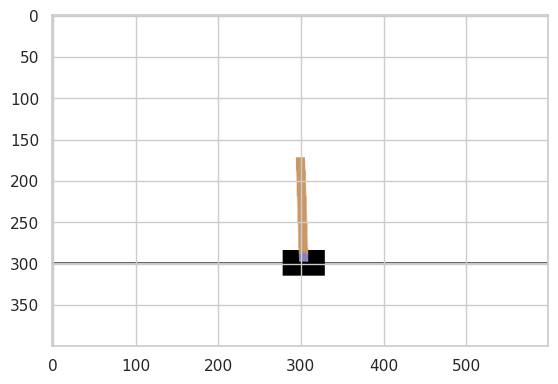

In [4]:
%matplotlib inline
sns.set_theme(font_scale=1., style="whitegrid")

# если есть вывод "<classname> has no attribute .env", удалите .env или обновите gym
env = gym.make("CartPole-v1", render_mode="rgb_array").env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

plt.imshow(env.render())
print("размерность вектора состояний dim =", state_dim)
print("n_actions =", n_actions)

env.close()

In [4]:
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

# Нейросетевая политика, основная задача (10 баллов)

Для текущей задачи будет использована упрощённая нейронная сеть, реализованная в библиотеке __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Что для решения задачи понадобится:

* `agent.partial_fit(states, actions)` - выполнение одного прохода (одной эпохи) по данным для настройки параметров. В ходе вызова данного метода происходит приближённая максимизация вероятности :actions: при условии :states:
* `agent.predict_proba(states)` - оценка вероятностей всех действий, матрица формы __[len(states), n_actions]__


In [4]:
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation="tanh",
)

# инициализация агента на размерности пространства состояний и пространства действий
agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [5]:
def generate_session(
    env,
    agent: MLPClassifier,
    t_max: int = 1000,
    test: bool = False,
    video: VideoRecorder = None
) -> tp.Tuple[tp.List]:
    """
    Сыграть отдельный эпизод, используя нейросетевую параметризацию агента.
    Останов после :t_max: шагов среды.
    """
    states, actions = [], []
    total_reward = 0

    s = env.reset()[0]

    for _ in range(t_max):
        if video is not None:
            video.capture_frame()
        # Используйте модель агента для оценки распределения на действия для текущего состояния :s:
        probs = agent.predict_proba(np.array([s])).reshape((n_actions,))

        assert probs.shape == (
            n_actions,
        ), "Нужно получить вектор вероятностей (функция np.reshape в помощь)"

        # Используйте текущую оценку политики для выбора действия
        if test:
            # на тестовом прогоне или на валидации используйте
            # детерминированную стратегию
            a = np.argmax(probs)
            # ^-- подсказка: попробуйте функцию np.argmax
        else:
            # сэмплирование пропорционально политике $\pi(a|s)$,
            # не нужно выбирать детерминированно наиболее вероятное действие
            a = np.random.choice(np.arange(n_actions), p=probs)
            # ^-- подсказка: попробуйте функцию np.random.choice

        new_s, r, done, _, _ = env.step(a)

        # Запись статистики текущего эпизода
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    if video is not None:
        video.close()
    return states, actions, total_reward

In [6]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
print("states:", np.array(dummy_states))
print("actions:", dummy_actions)
print("reward:", dummy_reward)

states: [[ 0.03839484  0.03119666  0.02059159  0.02077867]
 [ 0.03901877  0.22601736  0.02100717 -0.2653369 ]
 [ 0.04353912  0.03060197  0.01570043  0.03389715]
 [ 0.04415116  0.2254953   0.01637837 -0.25379106]
 [ 0.04866106  0.03014335  0.01130255  0.04401255]]
actions: [1, 0, 1, 0, 0]
reward: 5.0


### Шаги кросс-энтропийного метода
Общая схема кросс-энтропийного метода (CEM) приведена на странице 35 (параграф 2.2.4.) учебного [пособия](https://arxiv.org/pdf/2201.09746.pdf).

Глубокий CEM использует точно такую же стратегию, что и обычный CEM.

Главное отличие состоит в том, что теперь каждое наблюдение не число, а `float32` вектор.

In [6]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Выбрать states и actions из игр с rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, оба 1D lists of states и actions из наилучших эпизодов

    Просьба сохранять порядок elite states и actions
    [то есть сортированы по номерам эпизодов и в хронологическом порядке в каждом эпизоде]

    Просьба не считать по умолчанию states как целочисленные значения
    (они позже примут другой формат).
    """

    thres = np.percentile(rewards_batch, q=percentile)
    idx = rewards_batch >= thres
    # elite_states = []
    # elite_actions = []
    # for i in range(len(rewards_batch)):
    #     if rewards_batch[i] < thres:
    #         continue
    #     elite_states.extend(states_batch[i])
    #     elite_actions.extend(actions_batch[i])
    elite_states = np.concatenate(states_batch[idx])
    elite_actions = np.concatenate(actions_batch[idx]).flatten()

    # Заметим, что это отличается от табличного случая.
    # Теперь наша нейронная сеть обучается на одном объекте с входной размерностью `(1, n_states)`.
    # То есть следует использовать `np.squeeze`, чтобы избавиться от ведущего измерения в `select_elites`.

    # return np.array(elite_states), np.array(elite_actions)
    return elite_states, elite_actions

# Цикл обучения
Генерация эпизодов, выбор N лучших и обучение на них.

In [4]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    Функция-помощник, которая визуализирует процесс обучения.
    Никакой крутой математики здесь нет, только построение графиков.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    print("средняя награда = %.3f, порог=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Средние награды")
    plt.plot(list(zip(*log))[1], label="Пороги наград")
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],
        [0],
        [100],
        label="перцентиль",
        color="red",
    )
    plt.legend()
    plt.grid()

    clear_output(True)
    plt.show()

In [10]:
def train(
    env,
    agent: MLPClassifier,
    n_iters: int = 100,
    n_sessions: int = 100,
    percentile: int = 70,
) -> list:
    log = []
    for i in range(n_iters):
        print("Итерация метода № {}:".format(i + 1))
        # генерация новых эпизодов
        # states_batch = []
        # actions_batch = []
        # rewards_batch = []
        # for _ in range(n_sessions):
        #     session = generate_session(env, agent, t_max=1000)
        #     states_batch.append(session[0])
        #     actions_batch.append(session[1])
        #     rewards_batch.append(session[2])
        sessions = [generate_session(env, agent, t_max=500) for _ in range(n_sessions)]
        states_batch, actions_batch, rewards_batch = map(partial(np.array, dtype=object), zip(*sessions))

        elite_states, elite_actions = select_elites(
            states_batch, actions_batch, rewards_batch, percentile
        )

        agent.partial_fit(elite_states, elite_actions, range(n_actions))

        show_progress(
            rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
        )

        if np.mean(rewards_batch) > 190:
            print(
                "Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt."
            )
            break
    return log

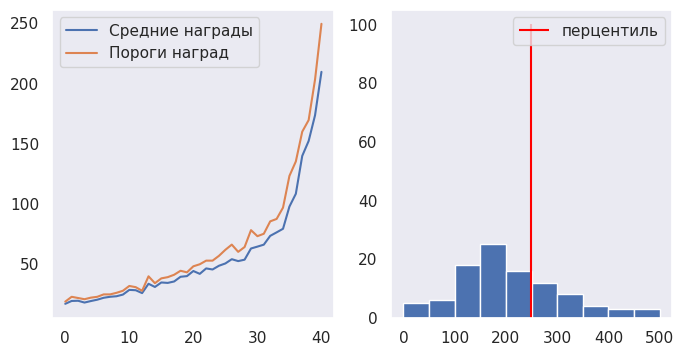

Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
CPU times: user 1min 21s, sys: 821 ms, total: 1min 22s
Wall time: 1min 22s


In [29]:
%%time

sns.set(font_scale=1.)
n_sessions = 100
percentile = 70

logs = train(env, agent, n_sessions=n_sessions, percentile=percentile)

# Результаты

In [30]:
# запись эпизодов
for kind, directory in [(True, "test"), (False, "sample")]:
    env = gym.make("CartPole-v1", render_mode="rgb_array").env
    directory = "videos/CartPole-v1/{}/{}".format(directory, directory)
    os.makedirs(os.path.dirname(directory), exist_ok=True)
    video = VideoRecorder(env, base_path=directory)
    sessions = [
        generate_session(env, agent, test=kind, video=video, t_max=500)
        for _ in range(100)
    ]
    video.close()

Moviepy - Building video videos/CartPole-v1/test.mp4.
Moviepy - Writing video videos/CartPole-v1/test.mp4



Moviepy - Done !
Moviepy - video ready videos/CartPole-v1/test.mp4
Moviepy - Building video videos/CartPole-v1/sample.mp4.
Moviepy - Writing video videos/CartPole-v1/sample.mp4



Moviepy - Done !
Moviepy - video ready videos/CartPole-v1/sample.mp4


Детерминированная политика:

In [31]:
# демонстрация видео
from IPython.display import HTML
import os


video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/CartPole-v1/test"))
)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        "./videos/CartPole-v1/test/" + video_names[-1]
    )
)

Стохастическая политика:

In [32]:
video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/CartPole-v1/sample"))
)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        "./videos/CartPole-v1/sample/" + video_names[-1]
    )
)

# Дополнительные задания

### Глубокий кросс-энтропийный метод

На данный момент у Вас должна быть достаточно хорошая награда в [CartPole-v1](https://www.gymlibrary.dev/environments/classic_control/cart_pole/), чтобы считать основное задание выполненным (см. ссылку). Время попробовать что-нибудь посложнее.

### Задания (вплоть до 5 баллов)

* __2.1__ Выбрать следующие среды: MountainCar-v0 и LunarLander-v2.
  * Для MountainCar, получить среднее вознаграждение __как минимум -150__
  * For LunarLander, получить среднее вознаграждение __как минимум +50__

Рекомендуем обратить внимание на раздел с советами ниже, это важно.

* __2.2__ Изучить зависимость скорости обучения агента от гипрепараметров алгоритма в среде MountainCar-v0. Постараться продемонстрировать возможность ускорения обучения хотя бы в два раза при грамотном подборе гиперпараметров
  * Очевидное улучшение: использовать [joblib](https://joblib.readthedocs.io/en/stable/) или multiprocessing
  * Попробовать переиспользовать сэмплы из 3-5 последних итераций при вычислении порога и при обучении
  * Поэкспериментировать с количеством итераций обучения и шагом метода обучения (learning rate) нейронной сети (смотреть params)

* __При сдаче задания требуется перечислить в данном файле, что было сделано и чего добились__
  
### Советы
* Страница Gym: [MountainCar](https://www.gymlibrary.dev/environments/classic_control/mountain_car/), [LunarLander](https://www.gymlibrary.dev/environments/box2d/lunar_lander/)
* Эпизоды в MountainCar могут длиться более 10k+ шагов. Убедитесь, что параметр ```t_max``` не меньше 10k.
 * Также может быть хорошей идеей строго отбирать награды через ">", а не ">=" (strictly_select_elites). Если 90% Ваших эпизодов имеют награду -10k и 20% лучше, тода если Вы используйте перцентиль 20% как порог, R >= порог __не может отклонить неуспешные эпизоды__, в то время как R > справляется с этим корректно.
* _проблема сред gym_: некоторые версии gym ограничивают эпизод 200 шагами. Это ограничивает возможности CEM в обучении в большинстве случаев. Убедитесь, что Ваш агент способен симулировать эпизоды с заданным __t_max__, и если нет, то попробуйте `env = gym.make("MountainCar-v0").env` или в ином случае избавьтесь от TimeLimit wrapper.
* Если Вы пользуетесь старой _swig_ библиотекой для LunarLander-v2, у Вас может возникнуть ошибка. Детали по [ссылке](https://github.com/openai/gym/issues/100) с решением проблемы.
* Если CEM не будет обучаться, то построение диаграмм распределения награды и запись видео эпизодов могут помочь: они Вас могут натолкнуть на идею исправления.
* 20-нейронной сети может не хватить, не стесняйтесь экспериментировать.

Ячейка с кодом ниже может оказаться полезной:

In [5]:
def visualize_mountain_car(env, agent):
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)
    grid = np.dstack(np.meshgrid(xs, vs)).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3)
    return probs

Функции-помощники для инициализации среды:

In [6]:
def get_env(name, classification=True):
    env = gym.make(name, render_mode="rgb_array").env

    env.reset()
    if classification:
        n_actions = env.action_space.n
    else:
        n_actions = sum(env.action_space.shape)
    state_dim = env.observation_space.shape[0]

    plt.imshow(env.render())
    print("state vector dim =", state_dim)
    print("n_actions =", n_actions)

    env.close()
    return env, n_actions, state_dim

Строгий отбор states и actions на основе перцентилей:

In [7]:
def strictly_select_elites(states_batch, actions_batch, rewards_batch, percentile=50, classification=True):
    """
    Выбрать states и actions из игр с rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, оба 1D lists of states и actions из наилучших эпизодов

    Просьба сохранять порядок elite states и actions 
    [то есть сортированы по номерам эпизодов и в хронологическом порядке в каждом эпизоде]

    Просьба не считать по умолчанию states как целочисленные значения
    (они позже примут другой формат).
    Отбор в случае решения задачи классификации и в случае решения задачи регрессии несколько отличаются.
    """

    thres = np.percentile(rewards_batch, q=percentile)
    idx = rewards_batch > thres
    if np.any(idx) == False:
        return [], []
    elite_states = np.concatenate(states_batch[idx])
    elite_actions = np.concatenate(actions_batch[idx])
    if classification:
        elite_actions = elite_actions.flatten()
    
    return elite_states, elite_actions

Обёртка для инициализации агента:

In [8]:
def init_agent(env, classification=True, **params):
    if classification:
        agent = MLPClassifier(
            hidden_layer_sizes=(64, 128, 64),
            activation="relu",
            random_state=42,
        )
    else:
        agent = MLPRegressor(
            hidden_layer_sizes=(64, 128, 64),
            activation="relu",
            random_state=42,
            warm_start=True,
            max_iter=1,
            batch_size=500,
        )

    agent.set_params(**params)

    if classification:
        n_actions = env.action_space.n
        agent.partial_fit([env.reset()[0]] * n_actions, range(n_actions), range(n_actions))
    else:
        n_actions = sum(env.action_space.shape)
        if n_actions > 1:
            agent.fit([env.reset()[0]], np.random.randn(1, n_actions))
        else:
            agent.fit([env.reset()[0]], np.random.randn(n_actions))

    return agent

Генератор эпизодов, приспособленный к параллелизации:

In [9]:
import pickle as pkl


def generate_parallel_session(
    agent: MLPClassifier | MLPRegressor,
    name: str = "MountainCar-v0",
    t_max: int = 10000,
    classification: bool = True,
    epsilon: float = 0.01,
    agent_mul_fac: float = 1.0,
    test: bool = False,
    env=None,
    video: tp.Optional[VideoRecorder] = None,
) -> tp.Tuple[tp.List]:
    """
    Сыграть отдельный эпизод, используя нейросетевую параметризацию агента.
    Останов после :t_max: шагов среды.
    """

    states, actions = [], []
    total_reward = 0

    if env is None:
        env = gym.make(name, render_mode="rgb_array").env
    if classification:
        n_actions = env.action_space.n
    else:
        n_actions = sum(env.action_space.shape)
    s = env.reset()[0]

    for t in range(t_max):
        if video is not None:
            video.capture_frame()
        if classification:
            probs = agent.predict_proba(np.array([s])).reshape((n_actions,))

            assert probs.shape == (
                n_actions,
            ), "Нужно получить вектор вероятностей (функция np.reshape в помощь)"

            if test:
                a = np.argmax(probs)
            else:
                a = np.random.choice(np.arange(n_actions), p=probs)
        else:
            expected_action = agent.predict(np.array([s])) * agent_mul_fac
            if test:
                a = expected_action
            else:
                a = np.random.randn(1, n_actions)[0] * epsilon + expected_action

        new_s, r, done, _, _ = env.step(a)

        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break

    del env, s, new_s, a

    return states, actions, total_reward

Функция для обучения агента:

In [10]:
from collections import deque

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)
    from joblib import Parallel, delayed
from functools import partial


def train_agent(
    classification: bool = True,
    epsilon: float = 0.01,
    name: str = "MountainCar-v0",
    n_train_steps: int = 100,
    n_game_steps: int = 15000,
    n_sessions: int = 100,
    percentile: int = 70,
    goal_score: int = -150,
    history_length: int = 4,
    n_jobs: int = 16,
    verbose: bool = True,
    agent_mul_fac=1.0,
    **params
) -> tp.Tuple[tp.Any]:
    env = gym.make(name, render_mode="rgb_array").env
    if classification:
        n_actions = env.action_space.n
    else:
        n_actions = sum(env.action_space.shape)

    agent = init_agent(env, classification, **params)

    if verbose:
        print("Шаг агента = {}".format(agent.learning_rate_init), flush=True)

    log = []
    sessions = deque([], history_length * n_sessions)

    for _ in range(n_train_steps):
        if n_jobs > 1:
            sessions.extend(
                Parallel(n_jobs=n_jobs)(
                    delayed(
                        partial(
                            generate_parallel_session,
                            agent,
                            name,
                            n_game_steps,
                            classification,
                            epsilon,
                            agent_mul_fac,
                            env=env,
                        )
                    )(x)
                    for x in [False] * n_sessions
                )
            )
        else:
            sessions.extend(
                [
                    generate_parallel_session(
                        agent,
                        name,
                        n_game_steps,
                        classification,
                        epsilon,
                        agent_mul_fac,
                        False,
                        env=env,
                    )
                    for _ in range(n_sessions)
                ]
            )

        states_batch, actions_batch, rewards_batch = map(
            partial(np.array, dtype=object), zip(*sessions)
        )
        elite_states, elite_actions = strictly_select_elites(
            states_batch, actions_batch, rewards_batch, percentile, classification
        )

        if len(elite_actions) > 0 and classification:
            agent.partial_fit(elite_states, elite_actions, range(n_actions))
            # agent.fit(elite_states, elite_actions)
        elif len(elite_actions) > 0 and not classification:
            elite_actions = (
                elite_actions
                if (len(elite_actions.shape) < 2) or (elite_actions.shape[1] > 1)
                else elite_actions.reshape(-1)
            )
            agent.fit(elite_states, elite_actions / agent_mul_fac)
            # agent.fit(elite_states, elite_actions / agent_mul_fac)

        if verbose:
            inter_min = np.min(rewards_batch)
            min_lim = -n_game_steps if -n_game_steps < inter_min else inter_min
            inter_max = np.max(rewards_batch)
            max_lim = goal_score if goal_score > inter_max else inter_max
            show_progress(
                rewards_batch, log, percentile, reward_range=[min_lim, max_lim]
            )

            if np.mean(rewards_batch) > goal_score:
                print(
                    "Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt."
                )
                break

    if verbose:
        mean_reward = np.mean(rewards_batch)
        threshold = np.percentile(rewards_batch, percentile)
        print("средняя награда = %.3f, порог=%.3f" % (mean_reward, threshold))
        del mean_reward, threshold

    del (
        env,
        sessions,
        states_batch,
        actions_batch,
        rewards_batch,
        elite_states,
        elite_actions,
    )

    return agent, log

Функция для постановки экспериментов, зависящих от набора гиперпараметров:

In [11]:
from time import time


def training_experiment(
    n_jobs_list: tp.List[int],
    history_length_list: tp.List[int],
    learning_rate_init_list: tp.List[float],
    n_train_steps_list: tp.List[int],
    n_samples: int = 5,
    name: str = "MountainCar-v0",
    n_game_steps: int = 10000,
    n_sessions: int = 100,
    percentile: int = 70,
    goal_score: int = -150,
    **params
) -> tp.List[tp.Dict[str, tp.Any]]:
    experiment_data = []

    for n_jobs in n_jobs_list:
        for history_length in history_length_list:
            for learning_rate_init in learning_rate_init_list:
                params["learning_rate_init"] = learning_rate_init
                for n_train_steps in n_train_steps_list:
                    elapsed_time_list = []
                    log_list = []

                    for i in range(n_samples):
                        print(
                            "Запуск: n_jobs = {}, history_length = {},\n".format(
                                n_jobs, history_length
                            )
                            + "                  learning_rate_init = {}, n_train_steps = {};\n".format(
                                learning_rate_init, n_train_steps
                            )
                            + "сэмпл {} из {}.".format(i + 1, n_samples),
                            flush=True,
                        )

                        elapsed_time = time()

                        agent, log = train_agent(
                            classification=True,
                            epsilon=0.01,
                            name=name,
                            n_train_steps=n_train_steps,
                            n_game_steps=n_game_steps,
                            n_sessions=n_sessions,
                            percentile=percentile,
                            goal_score=goal_score,
                            history_length=history_length,
                            n_jobs=n_jobs,
                            verbose=True,
                            **params
                        )

                        elapsed_time_list.append(time() - elapsed_time)

                        log_list.append(log)

                        del log, agent

                    results = {
                        "name": name,
                        "goal_score": goal_score,
                        "n_jobs": n_jobs,
                        "elapsed_time_list": elapsed_time_list,
                        "history_length": history_length,
                        "learning_rate_init": learning_rate_init,
                        "n_train_steps": n_train_steps,
                        "log_list": log_list,
                    }

                    experiment_data.append(results)

                    del elapsed_time_list, log_list
    return experiment_data

Функция-помощник для визуализации эффектов от переиспользования сэмплов:

In [12]:
def plot_history_length_experiment_results(df_data):
    history_length_vals = []
    train_step_vals = []
    reward_vals = []
    mean_threshold_vals = []

    for config in df_data:
        for log in config["log_list"]:
            mean_rewards, reward_thresholds = zip(*log)
            mean_rewards, reward_thresholds = list(mean_rewards), list(
                reward_thresholds
            )
            reward_vals.extend(mean_rewards)
            reward_vals.extend(reward_thresholds)
            train_steps_num = len(mean_rewards)
            train_step_vals.extend(range(train_steps_num))
            train_step_vals.extend(range(train_steps_num))
            history_length_vals.extend([config["history_length"]] * train_steps_num * 2)
            mean_threshold_vals.extend(["mean"] * train_steps_num)
            mean_threshold_vals.extend(["threshold"] * train_steps_num)

    df = pd.DataFrame(
        {
            "Переиспользованных шагов": history_length_vals,
            "Шаг №": train_step_vals,
            "Награда": reward_vals,
            "Вид награды": mean_threshold_vals,
        }
    )
    last_steps_count = np.sort(df.loc[:, "Переиспользованных шагов"].unique())
    max_n_colors = last_steps_count.size
    palette = dict(zip(last_steps_count, sns.hls_palette(max_n_colors, l=0.45, s=0.8)))

    sns.set(font_scale=1.35)
    g = sns.relplot(
        x="Шаг №",
        y="Награда",
        hue="Переиспользованных шагов",
        style="Вид награды",
        kind="line",
        data=df,
        height=8,
        aspect=1.5,
        palette=palette,
    )
    g.fig.suptitle(
        "Влияние количества переиспользованных шагов при обучении {}".format(
            df_data[0]["name"]
        )
    )
    clear_output(True)
    plt.show()

Функция-помощник для визуализации влияния шага обучения и количества итераций при обучении агента:

In [27]:
def plot_lrt_experiment_results(df_data):
    learning_rate_vals = []
    max_train_steps_vals = []
    train_step_vals = []
    reward_vals = []
    mean_threshold_vals = []

    for config in df_data:
        for log in config["log_list"]:
            mean_rewards, reward_thresholds = zip(*log)
            mean_rewards, reward_thresholds = list(mean_rewards), list(
                reward_thresholds
            )
            reward_vals.extend(mean_rewards)
            reward_vals.extend(reward_thresholds)
            train_steps_num = len(mean_rewards)
            train_step_vals.extend(range(train_steps_num))
            train_step_vals.extend(range(train_steps_num))
            learning_rate_vals.extend(
                [config["learning_rate_init"]] * train_steps_num * 2
            )
            max_train_steps_vals.extend([config["n_train_steps"]] * train_steps_num * 2)
            mean_threshold_vals.extend(["mean"] * train_steps_num)
            mean_threshold_vals.extend(["threshold"] * train_steps_num)

    df = pd.DataFrame(
        {
            "Шаг метода": learning_rate_vals,
            "Максимум шагов": max_train_steps_vals,
            "Шаг №": train_step_vals,
            "Награда": reward_vals,
            "Вид награды": mean_threshold_vals,
        }
    )
    lr_vals = np.sort(df.loc[:, "Шаг метода"].unique())
    max_n_colors = lr_vals.size
    palette = dict(zip(lr_vals, sns.hls_palette(max_n_colors, l=0.45, s=0.8)))

    sns.set(font_scale=1.35)
    g = sns.relplot(
        x="Шаг №",
        y="Награда",
        hue="Шаг метода",
        style="Вид награды",
        kind="line",
        row="Максимум шагов",
        data=df,
        height=6,
        aspect=1.8,
        palette=palette,
    )
    g.fig.suptitle(
        "Влияние шага метода и количества итераций на {}".format(df_data[0]["name"]),
        x=0.8,
        y=1.05,
    )
    leg = g._legend
    for lr, label in zip(lr_vals, leg.texts[1:]):
        label.set_text("{:.4f}".format(lr))
    clear_output(True)
    plt.show()

Функция для записи сэмплированных игровых эпизодов:

In [14]:
def record_sessions(
    agent, name, t_max=10000, classification=True, epsilon=0.01, agent_mul_fac=1.0, n_samples=10
):
    for kind, directory in [(True, "test"), (False, "sample")]:
        env = gym.make(name, render_mode="rgb_array").env
        env.reset()
        directory = f"videos/{name}/{directory}/{directory}"
        os.makedirs(os.path.dirname(directory), exist_ok=True)
        video = VideoRecorder(env, base_path=directory)
        sessions = [
            generate_parallel_session(
                agent=agent,
                name=name,
                t_max=t_max,
                classification=classification,
                epsilon=epsilon,
                agent_mul_fac=agent_mul_fac,
                test=kind,
                env=env,
                video=video,
            )
            for _ in range(n_samples)
        ]
        video.close()

Функция, позволяющая вставить запись игрового эпизода в ноутбук:

In [15]:
from IPython.display import HTML
def show_video(name, directory):
    path = "./videos/{}/{}".format(name, directory)
    video_names = list(filter(lambda s: s.endswith(".mp4"), os.listdir(path)))
    return HTML(
        """
    <video width="640" height="480" controls>
    <source src="{}" type="video/mp4">
    </video>
    """.format(
            path + "/" + video_names[-1]
        )
    )

Сетка параметров для проведения экспериментов:

In [16]:
n_jobs_list = [8, 16, 30]
history_length_list = [3, 4, 5]
learning_rate_init_list = [0.005, 0.001, 0.0003]

## Глубокий кросс-энтропийный метод в среде MountainCar-v0

state vector dim = 2
n_actions = 3


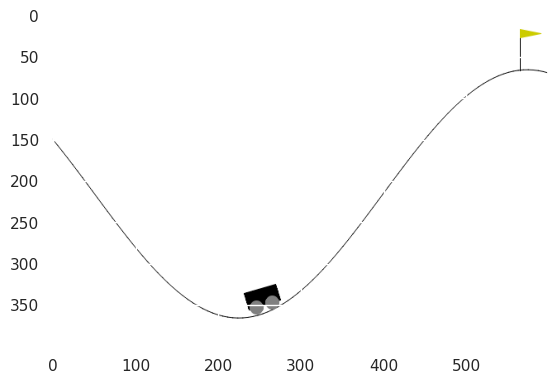

In [17]:
sns.set(font_scale=1.0)
env, n_actions, _ = get_env("MountainCar-v0")

In [18]:
env.observation_space, env.action_space

(Box([-1.2  -0.07], [0.6  0.07], (2,), float32), Discrete(3))

Поиск оптимального количества параллельных легковесных процессов (нитей) на конечной машине:

In [20]:
%%time
n_jobs_experiment_data = training_experiment(
    n_jobs_list=n_jobs_list,
    history_length_list=[4],
    learning_rate_init_list=[0.001],
    n_train_steps_list=[100],
    n_samples=3,
    percentile=75
)

sns.set(font_scale=1.)
pkl.dump(n_jobs_experiment_data, open('MountainCar-v0_n_jobs_experiment_data.pkl', 'wb'))
clear_output(True)

Запуск: n_jobs = 8, history_length = 4,
                  learning_rate_init = 0.001, n_train_steps = 100;
сэмпл 1 из 3.
Шаг агента = 0.001


/home/imumtozee/miniforge3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/imumtozee/miniforge3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/imumtozee/miniforge3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/imumtozee/miniforge3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/imumto

Визуализация результатов эксперимента:

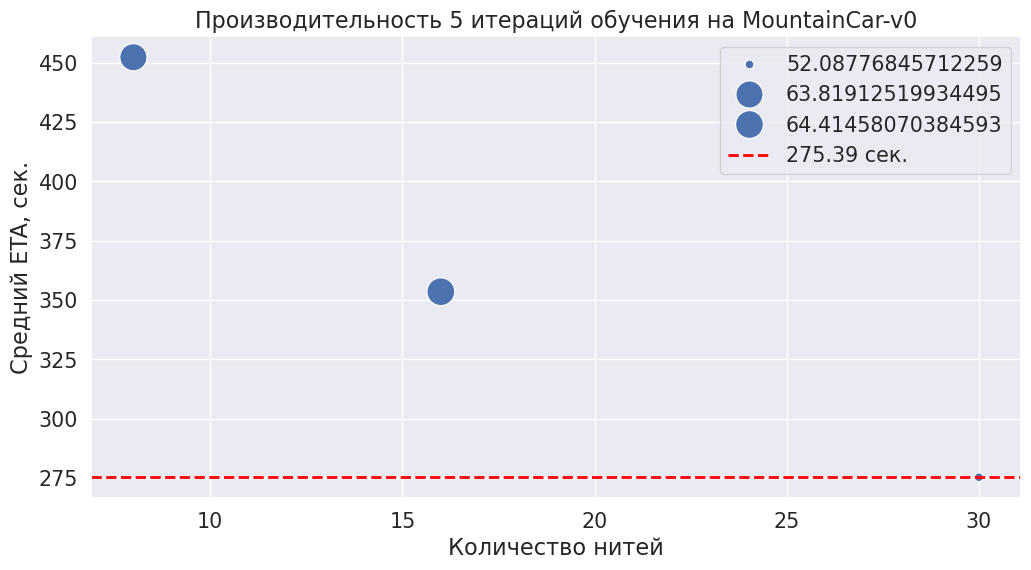

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd


n_jobs_vals = []
elapsed_time_vals = []
elapsed_time_vars = []

for config in n_jobs_experiment_data:
    n_jobs_vals.append(config["n_jobs"])
    elapsed_time_vals.append(np.mean(config["elapsed_time_list"]))
    elapsed_time_vars.append(np.std(config["elapsed_time_list"]))

df = pd.DataFrame(
    {
        "Количество нитей": n_jobs_vals,
        "Средний ETA, сек.": elapsed_time_vals,
        "Стандартное отклонение ETA": elapsed_time_vars,
    }
)

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.35)
plt.title(
    "Производительность 5 итераций обучения на {}".format(
        n_jobs_experiment_data[0]["name"]
    ),
    fontsize=16,
)
ax = sns.scatterplot(
    x="Количество нитей",
    y="Средний ETA, сек.",
    size="Стандартное отклонение ETA",
    sizes=(40, 400),
    data=df,
)
min_val = np.min(elapsed_time_vals)
ax.axhline(
    min_val, color="red", ls="--", linewidth=2, label="{:.2f} сек.".format(min_val)
)
plt.legend()
clear_output(True)
plt.show()

Исследование влияния переиспользования сэмплов в процессе обучения:

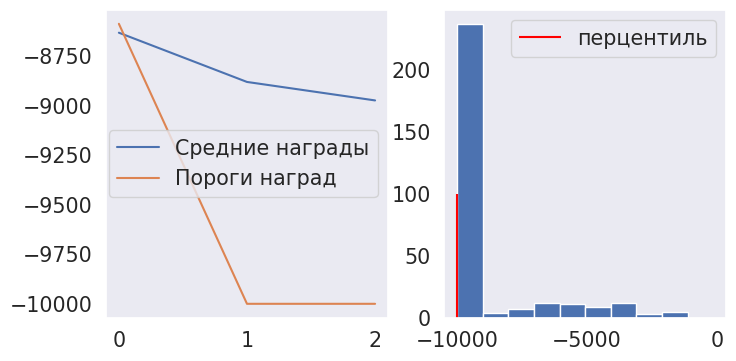

/home/imumtozee/miniforge3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/imumtozee/miniforge3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/imumtozee/miniforge3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/imumtozee/miniforge3/envs/rl/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/imumto

In [22]:
# %%time

history_length_experiment_data = training_experiment(
    n_jobs_list=[30],
    history_length_list=history_length_list,
    learning_rate_init_list=[0.001],
    n_train_steps_list=[100],
    n_samples=3,
    percentile=75
)

sns.set(font_scale=1.)
pkl.dump(history_length_experiment_data, open('MountainCar-v0_history_length_experiment_data.pkl', 'wb'))
clear_output(True)

Результаты текущего эксперимента:

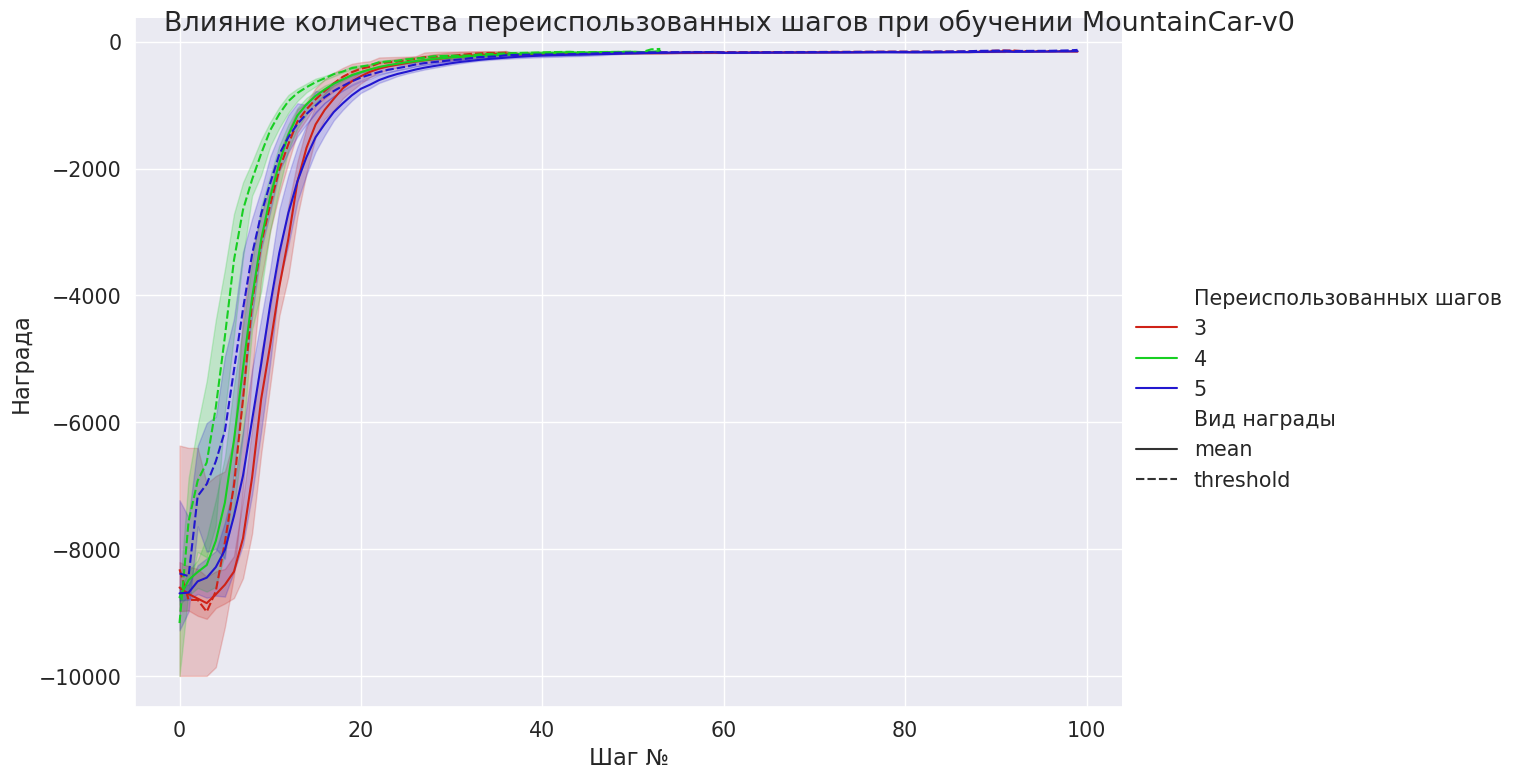

In [23]:
plot_history_length_experiment_results(history_length_experiment_data)

Поиск оптимального шага обучения для многослойного перцептрона (MLP) вместе c подбором количества шагов обучения:

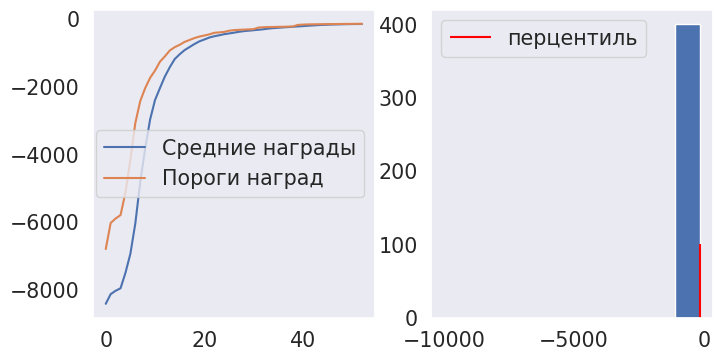

Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
средняя награда = -149.170, порог=-144.000


In [24]:
# %%time

lrt_experiment_data = training_experiment(
    n_jobs_list=[30],
    history_length_list=[4],
    learning_rate_init_list=learning_rate_init_list,
    n_train_steps_list=[100],
    n_samples=3,
    percentile=75
)

sns.set(font_scale=1.)
pkl.dump(lrt_experiment_data, open('MountainCar-v0_lrt_experiment_data.pkl', 'wb'))
clear_output(True)

Результаты текущего эксперимента:

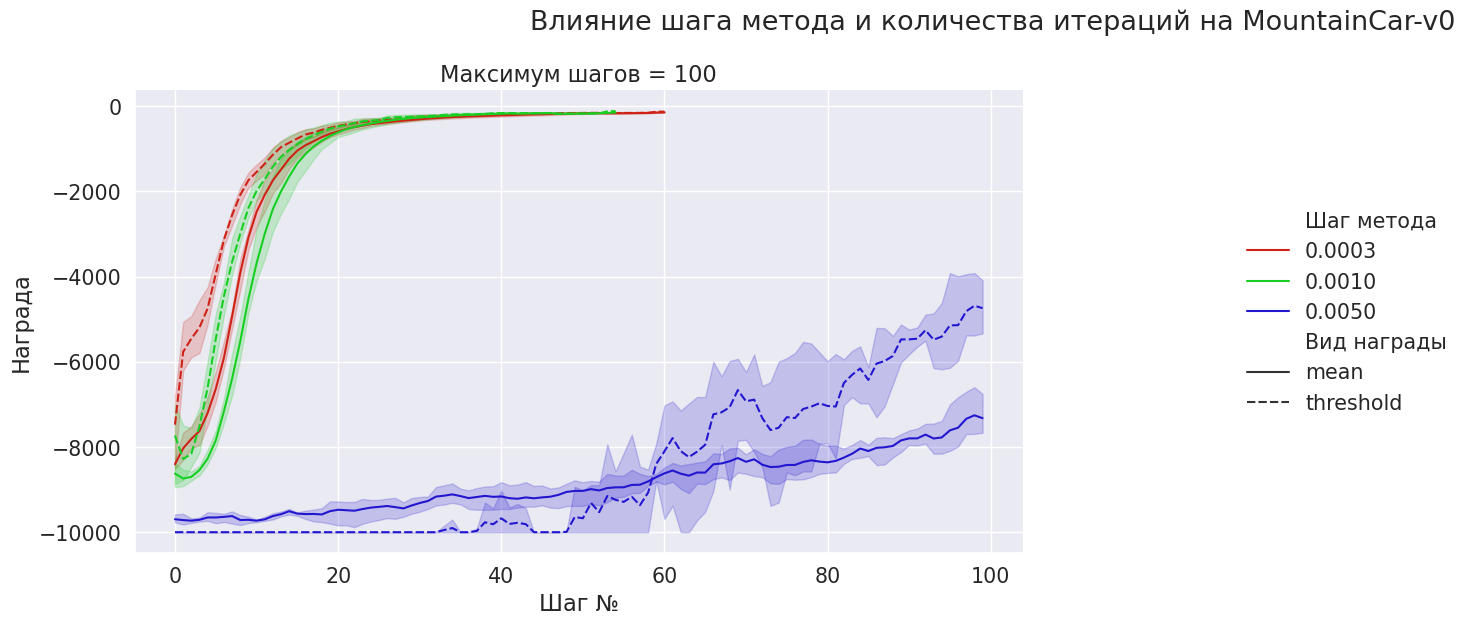

In [28]:
plot_lrt_experiment_results(lrt_experiment_data)

Обучение агента на задаче MountainCar-v0 с использованием подобранных ранее гиперпараметров:

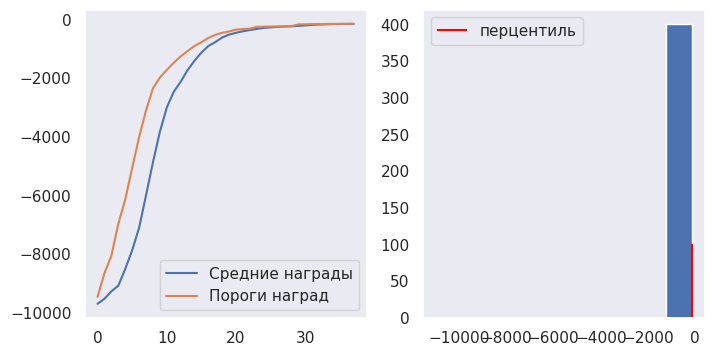

Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
средняя награда = -149.705, порог=-147.000


In [20]:
# %%time
sns.set(font_scale=1.0)
agent, _ = train_agent(
    percentile=75,
    n_jobs=30,
    learning_rate_init=0.001,
    solver="adam",
    history_length=4,
    n_game_steps=11_000,
    n_train_steps=100,
)

Визуализация действий обученного агента в зависимости скорости и положения:

state vector dim = 2
n_actions = 3


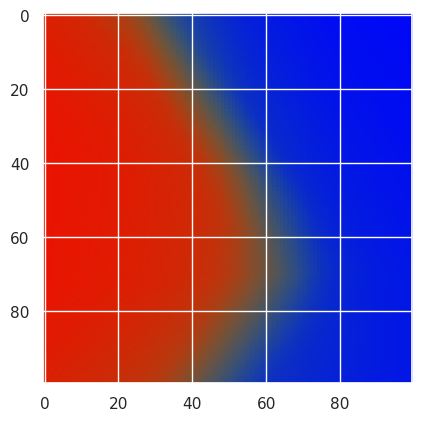

In [21]:
sns.set(font_scale=1.0)
env, _, _ = get_env("MountainCar-v0")
plt.imshow(visualize_mountain_car(env, agent))

Сэмпл детерминированной стратегии по въезду на холм:

In [22]:
record_sessions(agent, "MountainCar-v0")
show_video("MountainCar-v0", "test")

Moviepy - Building video videos/MountainCar-v0/test/test.mp4.
Moviepy - Writing video videos/MountainCar-v0/test/test.mp4



Moviepy - Done !
Moviepy - video ready videos/MountainCar-v0/test/test.mp4
Moviepy - Building video videos/MountainCar-v0/sample/sample.mp4.
Moviepy - Writing video videos/MountainCar-v0/sample/sample.mp4



Moviepy - Done !
Moviepy - video ready videos/MountainCar-v0/sample/sample.mp4


Сэмпл стохастической стратегии по въезду на холм:

In [23]:
show_video("MountainCar-v0", "sample")

## Обучение агента в среде LunarLander-v2

state vector dim = 8
n_actions = 4


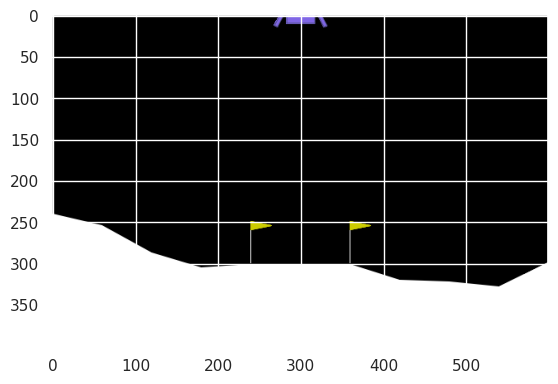

In [14]:
sns.set(font_scale=1.0)
env, n_actions, _ = get_env("LunarLander-v2")

In [15]:
env.observation_space, env.action_space

(Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
  -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
  1.       ], (8,), float32),
 Discrete(4))

Обучение агента:

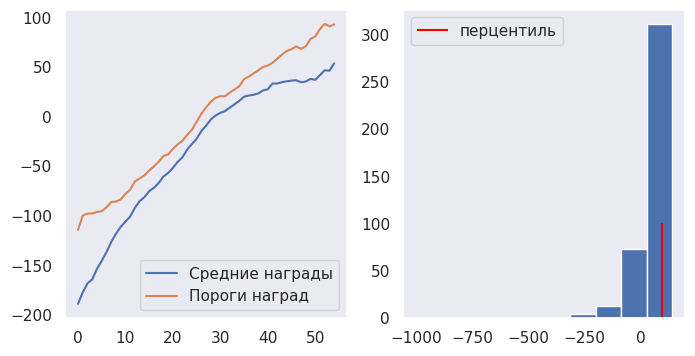

Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
средняя награда = 53.758, порог=92.892


In [24]:
# %%time
agent, _ = train_agent(
    percentile=75,
    name="LunarLander-v2",
    n_jobs=30,
    learning_rate_init=1e-3,
    solver="adam",
    history_length=4,
    n_game_steps=1_000,
    n_train_steps=100,
    n_sessions=100,
    goal_score=50,
)

Детерминированная стратегия:

In [25]:
record_sessions(agent, "LunarLander-v2", t_max=1000)
show_video("LunarLander-v2", "test")

Moviepy - Building video videos/LunarLander-v2/test/test.mp4.
Moviepy - Writing video videos/LunarLander-v2/test/test.mp4



Moviepy - Done !
Moviepy - video ready videos/LunarLander-v2/test/test.mp4
Moviepy - Building video videos/LunarLander-v2/sample/sample.mp4.
Moviepy - Writing video videos/LunarLander-v2/sample/sample.mp4



Moviepy - Done !
Moviepy - video ready videos/LunarLander-v2/sample/sample.mp4


Стохастическая стратегия:

In [26]:
show_video("LunarLander-v2", "sample")

<h1>Выводы:</h1>

- Архитектура нейронной сети:
    - взял в качестве MLP из 3 скрытых слоев с большим количеством нейронов во всех задачах: 64, 128, 64
    - это скорее всего дало большую reperesentative power агенту и помогло легче обучиться
    - взял в качестве функции активации ReLU из-за простоты вычислений и популярности
- Отбор элитных сессий:
    - нередко случалось так, что после строгого отбора элитных сессий, множество элитных стейтов оказалось пустым (все эпизоды завершились с самым низким ревордом), в таких случаях я просто скипал итерацию надеясь что на следующей итерации обучения получатся получше эпизоды
- Всегда переиспользовал эпизоды из 4 предыдущих итераций обучения, потому что это помогает сэкономить компьют: вместо семлпинга 400 эпизодов семплю 100 но все равно отбираю из 400. Предположение такое, что это работает если игры модели не сильно начинают отличаються на следующих итерациях
- Подбор гиперпараметров:
    - из-за ограничений по компьюту сетки подбирал максимально маленькие но с разумными значениями
    - как и ожидалось, увеличения числа процессов (8 -> 32) почти в 2 раза ускорило процесс обучения
    - с размером истории 4 обучение занимает меньше всех итераций: 50 vs 100
    - learning rate 1е-3 и 3e-4 не сильно отличаются по количеству итераций (+- 5-6), но 5-кратное увеличение шага обучения наоборот замедлило все

### Ещё дополнительное задание (вплоть до 5 баллов)

* __2.3 дополнительное__ Обучить агента в среде с непрерывным пространством действий с помощью `MLPRegressor` ([ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor)) или похожим образом.
  * Начните с [Pendulum-v0](https://www.gymlibrary.dev/environments/classic_control/pendulum/), попробуйте получить среднее вознаграждение **как минимум -300**.
  * Поскольку Ваш агент оценивает "среднее" действие, полезно добавить небольшой шум для исследования среды.
  * Обучить агентов в [MountainCarContinuous-v0](https://mgoulao.github.io/gym-docs/environments/classic_control/mountain_car_continuous/), [LunarLanderContinuous-v2](https://www.gymlibrary.dev/environments/box2d/lunar_lander/). За достижение награды ниже порогового значения будет начислено меньше баллов. Помните, что дискретные и непрерывные среды могут отличаться не только в пространстве действий. Требования на среднее вознаграждение такие же, как и в случае сред **MountainCar** и **LunarLander** ранее.
  * __При сдаче задания требуется перечислить в данном файле, что было сделано и чего добились__

## Обучение в Pendulum-v0

state vector dim = 3
n_actions = 1


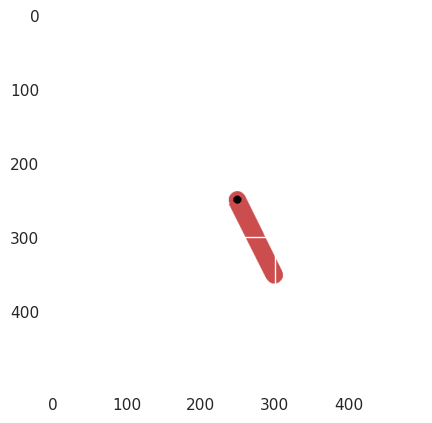

In [28]:
sns.set(font_scale=1.0)
env, n_actions, _ = get_env("Pendulum-v1", False)

In [29]:
env.observation_space, env.action_space

(Box([-1. -1. -8.], [1. 1. 8.], (3,), float32), Box(-2.0, 2.0, (1,), float32))

In [31]:
env.reset()[0]

array([-0.77537656, -0.6314991 ,  0.27700463], dtype=float32)

Обучение агента:

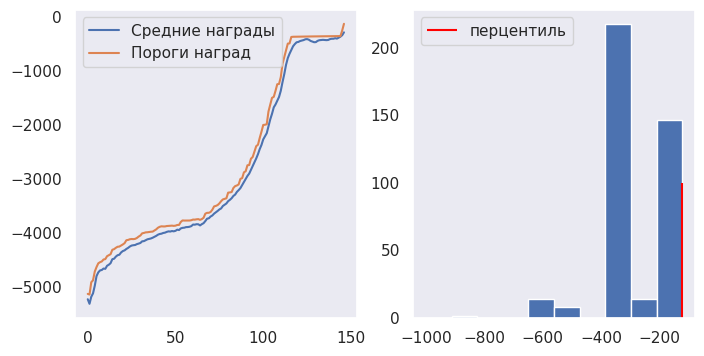

Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
средняя награда = -281.888, порог=-123.371


In [45]:
agent, _ = train_agent(
    percentile=80,
    n_jobs=30,
    learning_rate_init=0.001,
    solver="adam",
    history_length=4,
    n_game_steps=1000,
    n_train_steps=1000,
    n_sessions=100,
    name="Pendulum-v1",
    classification=False,
    epsilon=0.5,
    agent_mul_fac=2.0,
    goal_score=-300.0,
)

Детерминированная стратегия:

In [46]:
record_sessions(
    agent,
    "Pendulum-v1",
    t_max=1000,
    classification=False,
    epsilon=0.5,
    agent_mul_fac=2.0,
    n_samples=5,
)
show_video("Pendulum-v1", "test")

Moviepy - Building video videos/Pendulum-v1/test/test.mp4.
Moviepy - Writing video videos/Pendulum-v1/test/test.mp4



Moviepy - Done !
Moviepy - video ready videos/Pendulum-v1/test/test.mp4
Moviepy - Building video videos/Pendulum-v1/sample/sample.mp4.
Moviepy - Writing video videos/Pendulum-v1/sample/sample.mp4



Moviepy - Done !
Moviepy - video ready videos/Pendulum-v1/sample/sample.mp4


Стохастическая стратегия:

In [47]:
show_video("Pendulum-v1", "sample")

## Обучение MountainCarContinuous-v0

state vector dim = 2
n_actions = 1


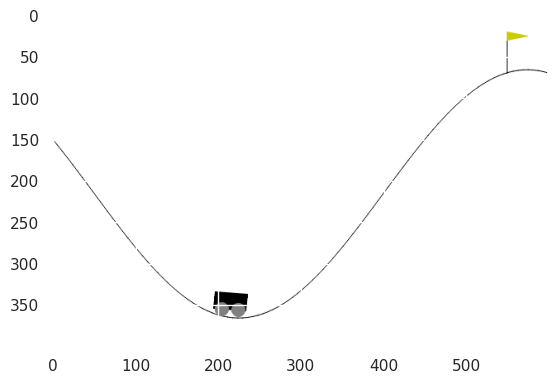

In [16]:
sns.set(font_scale=1.0)
env, n_actions, _ = get_env("MountainCarContinuous-v0", False)

In [17]:
env.observation_space, env.action_space

(Box([-1.2  -0.07], [0.6  0.07], (2,), float32), Box(-1.0, 1.0, (1,), float32))

In [18]:
env.reset()

(array([-0.43338868,  0.        ], dtype=float32), {})

Обучение агента:

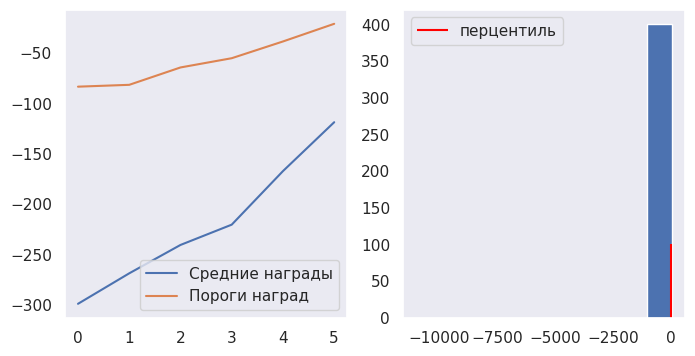

Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
средняя награда = -118.744, порог=-21.066


In [19]:
agent, _ = train_agent(
    percentile=75,
    n_jobs=30,
    learning_rate_init=0.001,
    solver="adam",
    history_length=4,
    n_game_steps=11_000,
    n_train_steps=100,
    name="MountainCarContinuous-v0",
    classification=False,
    epsilon=1.0,
    agent_mul_fac=1.0,
)

Детерминированная стратегия:

In [20]:
record_sessions(
    agent,
    "MountainCarContinuous-v0",
    t_max=10000,
    classification=False,
    epsilon=1.0,
    agent_mul_fac=1.0,
    n_samples=5,
)
show_video("MountainCarContinuous-v0", "test")

Moviepy - Building video videos/MountainCarContinuous-v0/test/test.mp4.
Moviepy - Writing video videos/MountainCarContinuous-v0/test/test.mp4



Moviepy - Done !
Moviepy - video ready videos/MountainCarContinuous-v0/test/test.mp4
Moviepy - Building video videos/MountainCarContinuous-v0/sample/sample.mp4.
Moviepy - Writing video videos/MountainCarContinuous-v0/sample/sample.mp4



Moviepy - Done !
Moviepy - video ready videos/MountainCarContinuous-v0/sample/sample.mp4


Стохастическая стратегия:

In [21]:
show_video("MountainCarContinuous-v0", "sample")

## Обучение LunarLanderContinuous-v2

state vector dim = 8
n_actions = 2


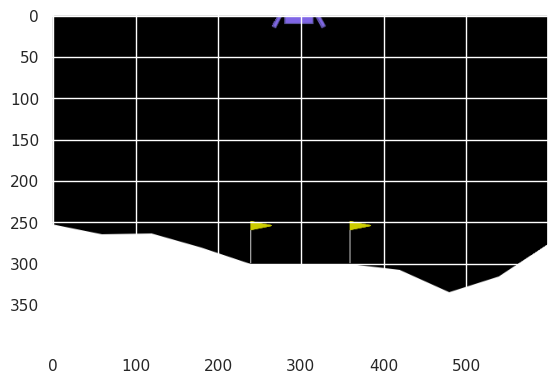

In [35]:
sns.set(font_scale=1.0)
env, n_actions, _ = get_env("LunarLanderContinuous-v2", False)

In [36]:
env.observation_space, env.action_space

(Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
  -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
  1.       ], (8,), float32),
 Box(-1.0, 1.0, (2,), float32))

Обучение агента:

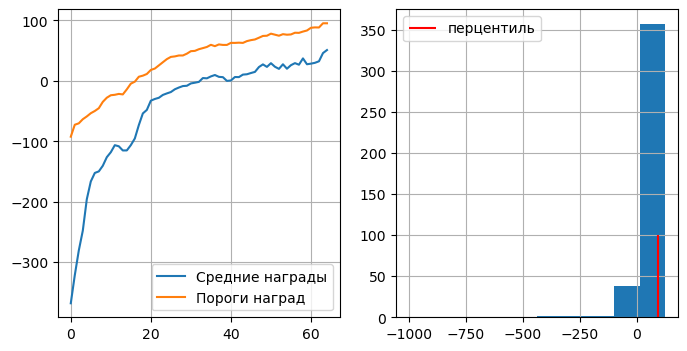

Вы выиграли! Можете прервать процедуру обучения с помощью сигнала KeyboardInterrupt.
средняя награда = 51.051, порог=95.367


In [28]:
agent, _ = train_agent(
    percentile=90,
    name="LunarLanderContinuous-v2",
    n_jobs=30,
    learning_rate_init=1e-3,
    solver="adam",
    history_length=4,
    n_game_steps=1_000,
    n_train_steps=100,
    n_sessions=100,
    goal_score=50.0,
    classification=False,
    epsilon=1.0,
    agent_mul_fac=1.0,
)

Детерминированная стратегия:

In [29]:
record_sessions(
    agent,
    "LunarLanderContinuous-v2",
    t_max=1000,
    classification=False,
    epsilon=1.0,
    agent_mul_fac=1.0,
)
show_video("LunarLanderContinuous-v2", "test")

Moviepy - Building video videos/LunarLanderContinuous-v2/test/test.mp4.
Moviepy - Writing video videos/LunarLanderContinuous-v2/test/test.mp4



Moviepy - Done !
Moviepy - video ready videos/LunarLanderContinuous-v2/test/test.mp4
Moviepy - Building video videos/LunarLanderContinuous-v2/sample/sample.mp4.
Moviepy - Writing video videos/LunarLanderContinuous-v2/sample/sample.mp4



Moviepy - Done !
Moviepy - video ready videos/LunarLanderContinuous-v2/sample/sample.mp4


Стохастическая стратегия:

In [30]:
show_video("LunarLanderContinuous-v2", "sample")

<h1>ВЫВОДЫ:</h1>

- архитектура: та же что и в дискретных пространствах
- в игре Pendulum-v1 (v1 потому что v0 уже deprecated и по функциональности между ними отличий нет) взять больший перцентиль и количество шагов обучения помогло сойтись до желваемого реворда
- в игре MountainCarCountinous-v0 неоижданно быстро все сошлось чем в дисркетном случае, в по видео игры видно что тележка очень медленно доходит до флажка
- в LunarLanderCOntinous-v2 тоже помогло поставить больший перцентиль для ускорения обучения